In [ ]:
import math
import yfinance as yf
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import datetime
plt.style.use('fivethirtyeight')
#!pip install twilio

[*********************100%%**********************]  1 of 1 completed


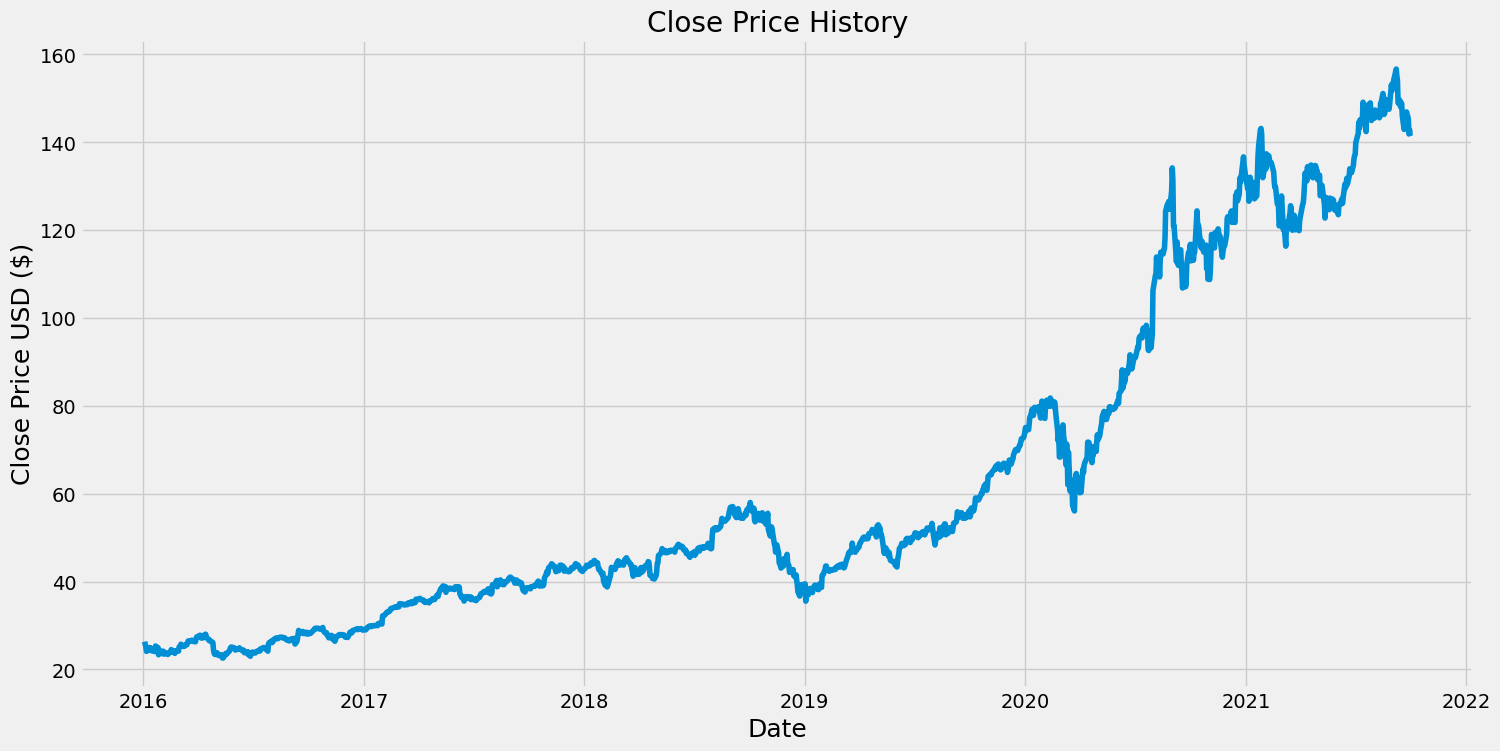

In [ ]:
# Data Preprocessing
# Getting the stock quote using the ticker
df = yf.download('AAPL', start='2016-01-01', end='2021-10-01')

# Plotting close price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

# Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Converting the dataframe to a numpy array
dataset = data.values

# Computing the number of rows to train the model
training_data_len = math.ceil( len(dataset) *.8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Creating the scaled training data set
train_data = scaled_data[0:training_data_len  , : ]

# Spliting the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

10/10 [==============================] - 1s 23ms/step


<ipython-input-3-8bb5e87154ff>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


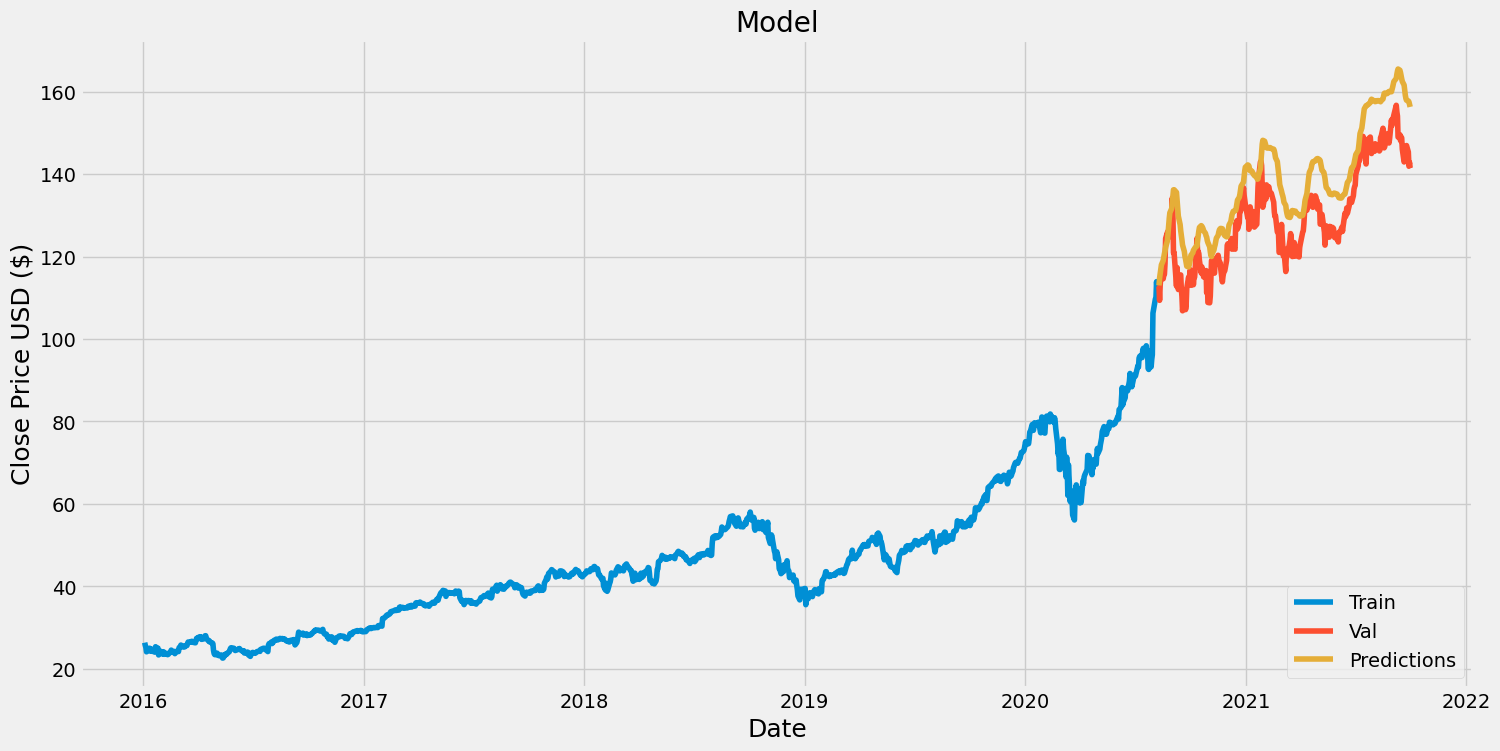

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 24ms/step
[[155.5655]]
[*********************100%%**********************]  1 of 1 completed
Date
2016-01-04     26.337500
2016-01-05     25.677500
2016-01-06     25.174999
2016-01-07     24.112499
2016-01-08     24.240000
                 ...    
2021-09-24    146.919998
2021-09-27    145.369995
2021-09-28    141.910004
2021-09-29    142.830002
2021-09-30    141.500000
Name: Close, Length: 1447, dtype: float64


In [ ]:
#LSTM network modelling
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Calculating the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

#Creating the data for the final graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

valid

#Quote
apple_quote = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)
apple_quote2 = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
print(apple_quote2['Close'])

#SMS
#from twilio.rest import Client

#account_sid = "AC175e7ea054d0ac4687e9b8e73ffdbad4"
#auth_token = "7a952f7d0ff07d9e2d9a55abe748027f"

#client = Client(account_sid, auth_token)

#client.api.account.messages.create(
#    to="+919910418997",
#    from_="+15402355432",
#    body=(pred_price)
#)

#End